In [1]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [2]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [3]:
!cat ../input/blood-cell-detection-datatset/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [4]:
ls -1 ../input/blood-cell-detection-datatset/train/images | wc -l

765


In [5]:
# Load the YAML file
with open('../input/blood-cell-detection-datatset/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data. You must use absolute path, relative path won't work
data_yaml['train'] = '/kaggle/input/blood-cell-detection-datatset/train/images'
data_yaml['val'] = '/kaggle/input/blood-cell-detection-datatset/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

## Set the data directory

In [6]:
data_dir = Path("../input/blood-cell-detection-datatset")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [7]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


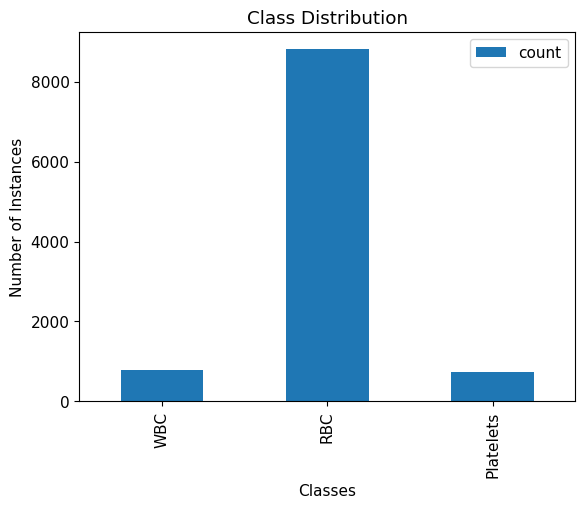

In [8]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [9]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))
        
        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

<AxesSubplot:>

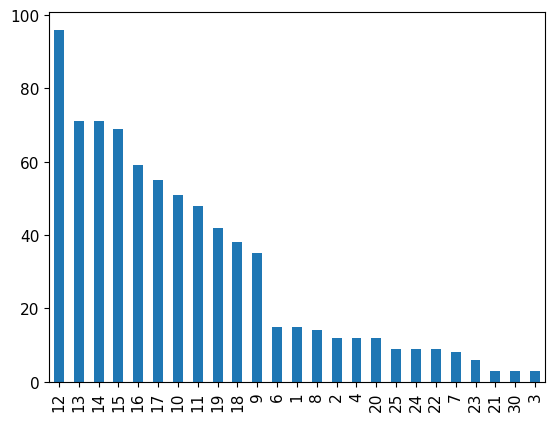

In [10]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<AxesSubplot:>

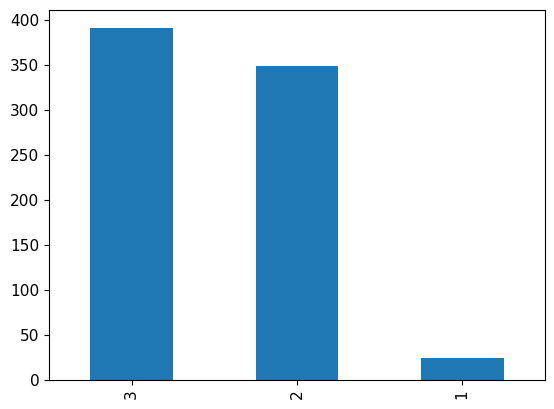

In [11]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

Most images have either 2 or 3 classes in them. 

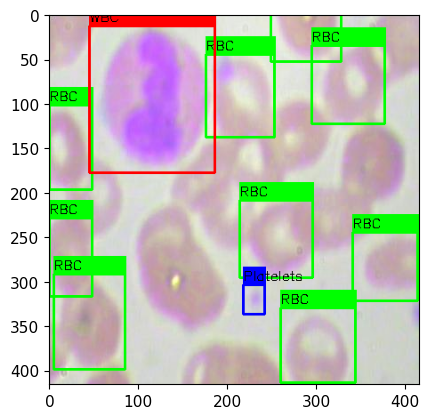

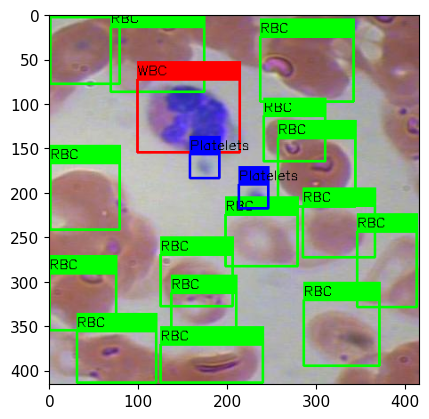

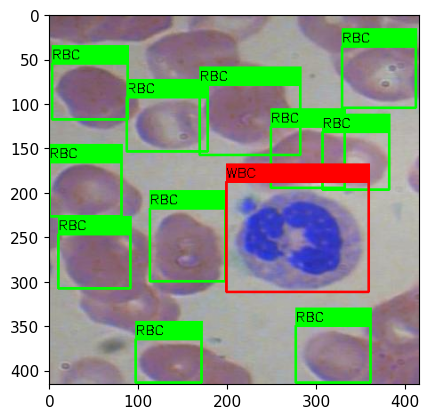

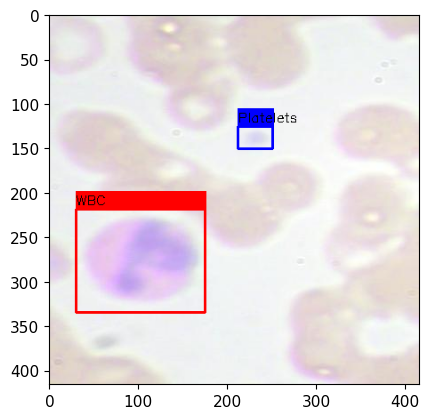

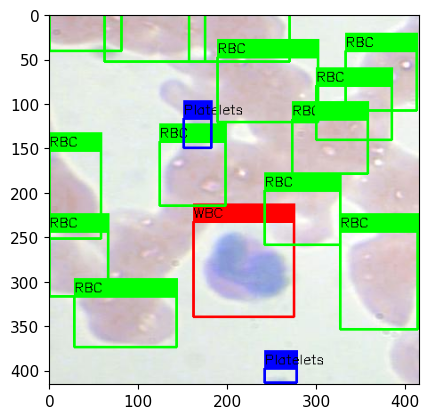

In [12]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

# Defining the model

Let's choose the large YOLOv8 model.

In [13]:
baseline_model = YOLO('yolov8x.pt')

  0%|          | 0.00/131M [00:00<?, ?B/s]

In [14]:
params = {
    'data':'data.yaml',
    'imgsz':416,
    'epochs':25,
    'optimizer':'Adam',
    'pretrained':True,
    'lr0':0.1,
    'lrf': 0.00001,
    'cos_lr': True
}

In [15]:
results = baseline_model.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.Conv                  [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.Conv                  [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.C2f                   [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.Conv                  [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.C2f                   [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.Conv                  [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.C2f                   [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

AMP: checks passed ✅
optimizer: Adam(lr=0.1) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias
train: Scanning /kaggle/input/blood-cell-detection-datatset/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:01<00:00, 385.38it/s]
train: WARNING ⚠️ Cache directory /kaggle/input/blood-cell-detection-datatset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Scanning /kaggle/input/blood-cell-detection-datatset/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 88.83it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/blood-cell-detection-datatset/valid is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Startin

# Understanding the results

This output shows the performance of the YOLOv8 model on the validation dataset. Specifically, it shows the precision, recall, and mAP (mean average precision) scores for each class and all combined classes. 

Let's breakdown what we're seeing here:

`Class:` This column shows the name of the class being evaluated. The model is evaluated on Platelets, RBC, and WBC in this example.

`Images`: This column shows the number of images in the test dataset containing at least one instance of the evaluated class.

`Instances`: This column shows the total number of class instances in the test dataset.

`Box(P)`: This column shows the precision score for the bounding boxes of the class. Precision measures the fraction of predicted bounding boxes that are correct.

`Box(R)`: This column shows the recall score for the bounding boxes of the class. Recall measures the fraction of true bounding boxes detected by the model.

`mAP50`: This column shows the mean average precision (mAP) score at a threshold of 50%. mAP is a common metric used to evaluate the performance of object detection models.

`mAP50-95`: This column shows the mAP score over a range of thresholds from 50% to 95%.

Object detection aims to achieve high precision and recall scores, indicating that the model is accurately detecting and localizing the objects in the image. The mAP score provides an overall measure of the model's performance, considering precision and recall. A higher mAP score indicates better performance.

# Changing more parmeters

Now let's take the trained baseline model and tweak some of the default settings.

In this iteration, let's enable label smoothing. Label smoothing is a regularization technique commonly used in deep learning to prevent overfitting and improve the model's generalization. In object detection, label smoothing can improve the model's performance by reducing the effect of noisy or incorrect annotations.

In object detection, each object in an image is labelled with a bounding box and a class label. 

The class label is typically a one-hot encoded vector. One element is set to 1 to indicate the presence of the corresponding object class, and all other elements are set to 0. However, the one-hot encoding assumes that the labels are completely accurate, which may not be the case in practice due to human annotation errors or ambiguity in the data.

Label smoothing addresses this issue by replacing the one-hot encoding with a smoothed distribution over the classes. 

Instead of assigning a value of 1 to the true class label and 0 to all other labels, the smoothed distribution assigns a small non-zero value (e.g., 0.1) to the true class label and a small non-zero value (e.g., 0.05) to all other labels. This has treduceseffect of noisy or incorrect annotations, as the model is encouraged to be less confident about the training labels and more robust to small changes in the input. The benefits of label smoothing for object detection include improved accuracy and generalization and reduced sensitivity to the choice of hyperparameters, such as learning rate and weight decay. 

There is a tradeoff: label smoothing can also reduce the model's ability to fit the training data precisely. Use it judiciously and with other regularization techniques such as dropout and weight decay.

In [16]:
params['label_smoothing'] = 0.15

In [17]:
# note: your path may differ from what I have here, check the output from the run above for details
model_2 =  YOLO('runs/detect/train/weights/best.pt')
model_2.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/best.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

# Augmentations

When working with blood cell images, it's essential to choose augmentations that preserve the characteristics of the cells while increasing the model's robustness to variations in the dataset. 

`hsv_h`: 0.02. Based on the training data, the hue of the blood cells can vary slightly, so a slightly larger fraction for hue augmentation can help to introduce more variation in the colour of the blood cells.

`hsv_s`: 0.5. The saturation of the blood cells appears to vary significantly in the training data, so a moderate fraction for saturation augmentation can help to introduce more contrast and make the blood cells more visible.

`hsv_v`: 0.3. The brightness of the blood cells varies slightly in the training data, so a moderate fraction for value augmentation can help to adjust the brightness and enhance the contrast between the blood cells and the background.

`degrees`: 5.0. The blood cells are mostly oriented in a horizontal or vertical direction in the training data, so a small rotation of up to 5 degrees can help to introduce some variation in the orientation of the blood cells.

`translate`: 0.05. Based on the training data, the blood cells can vary in position within the image, so a small fraction for translation can help to introduce more variation while keeping the blood cells within the same image.

`scale`: 0.3. The size of the blood cells varies significantly in the training data, so a moderate gain for scaling can help adjust the blood cells' size and introduce more variation.

`shear`: 0.0. The blood cells appear mostly circular in the training data, so shearing the images may not be necessary.

`perspective`: 0.0. The blood cells appear to be viewed from a fixed angle in the training data, so introducing perspective distortion may not be necessary.

`flipud`: 0.0. Flipping the images upside down may not be necessary for blood cell images, as the cells are typically viewed from a specific orientation.

`fliplr`: 0.3. Flipping the images horizontally can help to introduce more variation while keeping the orientation of the blood cells consistent.

`mosaic`: 0.5. Mosaic augmentation can help introduce more variation by combining multiple images into one image. However, using it too frequently may introduce too much variation and make the model less robust to the data.

`mixup`: 0.0. Mixup augmentation may not be necessary for blood cell images, as the cells are typically homogeneous and do not have distinct features. Mixing the images may introduce unnecessary variation that may be detrimental to the model's performance.

In [18]:
params['hsv_h'] = 0.02
params['hsv_s'] = 0.50
params['hsv_v'] = 0.30
params['degrees'] = 5.0
params['translate'] = 0.05
params['scale'] = 0.3
params['shear'] = 0.0
params['perspective'] = 0.0
params['flipud'] = 0.0
params['fliplr'] = 0.30
params['mosaic'] = 0.50
params['mixup'] = 0.0

In [19]:
model_3 =  YOLO('runs/detect/train2/weights/best.pt')
model_3.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train2/weights/best.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

# Focal Loss


Focal loss gamma is a hyperparameter that controls the degree to which the focal loss function focuses on hard examples during training. 

Focal loss is commonly used in object detection and other computer vision tasks, and is designed to address the problem of class imbalance in the training data. Like our situation where the Platelet and WBC classes have far fewer examples than the RBC examples. In situations like this the model may struggle to learn to recognize those under represented classes.

How does the focal loss work?

It modifies the standard cross-entropy loss function by introducing a tunable parameter `gamma`, which controls the rate at which the contribution of easy examples to the loss is reduced. Specifically, the focal loss function assigns a higher weight to hard examples (i.e., misclassified with high confidence) and a lower weight to easy examples (i.e., correctly classified with high confidence). 

The gamma parameter controls the rate at which the weight assigned to easy examples is reduced. 

A higher gamma value (e.g., 2) reduces the weight assigned to easy examples more quickly, making the loss more focused on hard examples. A lower gamma value (e.g., 0.5) gradually reduces the weight assigned to easy examples, making the loss less focused on hard examples.

The value for gamma is typically choose a value by cross-validation or grid search, since it can have a significant impact on the performance of the model.

For this example, we will set the value to be 

In [22]:
params['fl_gamma'] = 2

In [23]:
model_4 =  YOLO('runs/detect/train3/weights/best.pt')
model_4.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train3/weights/best.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

In [24]:
params['box'] = 10.0
params['cls'] = 2.0
params['dfl'] = 2.0

In [25]:
model_5 =  YOLO('runs/detect/train4/weights/best.pt')
model_5.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=runs/detect/train4/weights/best.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

In [26]:
params

{'data': 'data.yaml',
 'imgsz': 416,
 'epochs': 25,
 'optimizer': 'Adam',
 'pretrained': True,
 'lr0': 0.1,
 'lrf': 1e-05,
 'cos_lr': True,
 'label_smoothing': 0.15,
 'hsv_h': 0.02,
 'hsv_s': 0.5,
 'hsv_v': 0.3,
 'degrees': 5.0,
 'translate': 0.05,
 'scale': 0.3,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.3,
 'mosaic': 0.5,
 'mixup': 0.0,
 'fl_gamma': 2,
 'box': 10.0,
 'cls': 2.0,
 'dfl': 2.0}

In [27]:
model = YOLO('yolov8x.pt')
model.train(**params)

Ultralytics YOLOv8.0.57 🚀 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=25, patience=50, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=